In [2]:
import numpy as np
import arepo
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
import matplotlib as mpl
import h5py as h5
import re

from scipy.ndimage import gaussian_filter

In [3]:
sim_list = ['Nbody', 'phantom-vacuum-Sg20-Rc3.5', 'phantom-vacuum-Sg10-Rc3.5']

basepath = '/n/holystore01/LABS/hernquist_lab/Users/abeane/starbar_runs/runs/'

def read_snap(idx, sim_idx, lvl='lvl3', parttype=[0], 
              fields=['Coordinates', 'Masses', 'Velocities', 'ParticleIDs', 'Potential'],
              basepath = basepath):
    
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output'
    return arepo.Snapshot(fname, idx, parttype=parttype, fields=fields, combineFiles=True)

def read_sfr(sim_idx, lvl='lvl3', basepath = basepath):
    fname = basepath + sim_list[sim_idx] + '/' + lvl + '/output/sfr.txt'
    return np.genfromtxt(fname)

def read_fourier(sim_idx, lvl='lvl3', basepath='/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/analysis/'):
    sim = sim_list[sim_idx]
    f = h5.File(basepath+'/fourier_component/data/fourier_'+sim+'-'+lvl+'.hdf5', mode='r')
    return f

In [4]:
def rotate_pos(pos, ang):

    Rmat = np.array([[np.cos(ang), -np.sin(ang), 0.0],
                     [np.sin(ang),  np.cos(ang), 0.0],
                     [0.0,         0.0,          1.0]])
    
    pos = np.swapaxes(pos, 0, 1)
    pos = np.matmul(Rmat, pos)
    pos = np.swapaxes(pos, 0, 1)
    
    return pos

In [4]:
from photutils.isophote import EllipseGeometry
geometry = EllipseGeometry(x0=75, y0=75, sma=20, eps=0.5,
                           pa=20.0 * np.pi / 180.0)

(0.0, 150.0)

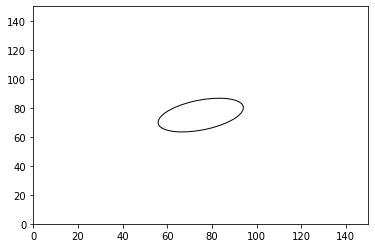

In [5]:
import matplotlib.pyplot as plt
from photutils.aperture import EllipticalAperture
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                          geometry.sma * (1 - geometry.eps),
                          geometry.pa)
plt.figure()
aper.plot(color='k')
plt.xlim(0, 150)
plt.ylim(0, 150)

In [35]:
snapnum_N = 800
snapnum_S = 500

sn = read_snap(snapnum_N, 0, parttype=[1, 2, 4])
center = sn.part1.pos.value[np.argmin(sn.part1.pot)]

In [36]:
fourierN = read_fourier(0)
fourierS = read_fourier(1)

phiN = np.arctan2(fourierN['snapshot_'+str(snapnum_N)]['A2i'][5], 
                  fourierN['snapshot_'+str(snapnum_N)]['A2r'][5])
phiS = np.arctan2(fourierS['snapshot_'+str(snapnum_S)]['A2i'][5], 
                  fourierS['snapshot_'+str(snapnum_S)]['A2r'][5])

In [37]:
disk_pos = np.copy(sn.part2.pos.value) - center
# disk_pos = np.concatenate((disk_pos, sn.part4.pos.value - center))
bangle = phiN/2.0
disk_pos = rotate_pos(disk_pos, -bangle)

disk_vel = sn.part2.vel.value
# disk_vel = np.concatenate((disk_vel, sn.part4.vel.value))
# disk_vel = rotate_pos(disk_vel, -bangle)

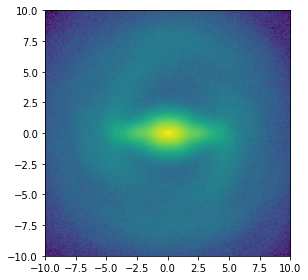

In [38]:
nres = 512

range_xy = [[-10, 10], [-10, 10]]
# center = np.array([200., 200., 200.])

x = disk_pos[:,0]
y = disk_pos[:,1]
heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=range_xy)
# heatmap_xy = gaussian_filter(heatmap_xy, sigma=16)

extent = [range_xy[0][0], range_xy[0][1], range_xy[1][0], range_xy[1][1]]

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()


In [39]:
from photutils.isophote import EllipseGeometry, Ellipse
geometry = EllipseGeometry(x0=0.0, y0=0.0, sma=20, eps=0.5,
                           pa=0.0 * np.pi / 180.0)

(<matplotlib.patches.Ellipse at 0x2b777c502af0>,)

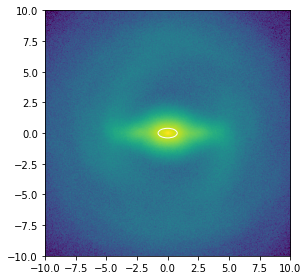

In [40]:
aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma*20/nres,
                          20/nres *geometry.sma * (1 - geometry.eps),
                          geometry.pa)

fig, ax = plt.subplots(1, 1)

ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

aper.plot(color='w')

In [53]:
heatmap = np.log10(heatmap_xy.T)
heatmap[heatmap==np.nan] = 1e-12

ellipse = Ellipse(heatmap)

<ipython-input-53-27e8223427c7>:1: RuntimeWarning: divide by zero encountered in log10
  heatmap = np.log10(heatmap_xy.T)


In [54]:
iso = ellipse.fit_isophote(100)

In [55]:
isolist = ellipse.fit_image(step=1.0, minsma=10.0, maxsma=256, linear=True)

/n/home01/abeane/.local/lib/python3.8/site-packages/photutils/isophote/sample.py:350: RuntimeWarning: invalid value encountered in double_scalars
  gradient = (mean_g - self.mean) / self.geometry.sma / step


In [59]:
k = np.argmax(isolist.eps)
print(isolist.sma[k] * 20 / nres)

7.734375


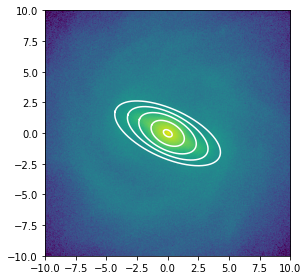

In [68]:
fig, ax = plt.subplots(1, 1)

smas = np.linspace(10, 120, 5)
for sma in smas:
    iso = isolist.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    x = (x-nres/2) * (20/nres)
    y = (y-nres/2) * (20/nres)
    ax.plot(x, y, color='white')
    
ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
# ax.imshow(heatmap_xy.T, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()

In [69]:
key = np.argmax(isolist.eps)
isolist.sma[key]

131.24847955717843

In [70]:
isolist.sma[key] * 20/nres

5.126893732702282

In [64]:
import pickle
pickle.dump(isolist, open('tmp.p', 'wb'))

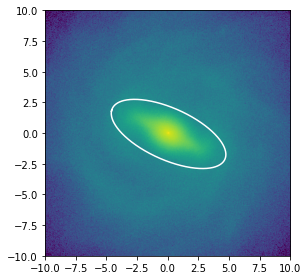

In [53]:
fig, ax = plt.subplots(1, 1)

key = np.argmax(isolist.eps)
sma = isolist.sma[key]
iso = isolist.get_closest(sma)
x, y, = iso.sampled_coordinates()
x = (x-nres/2) * (20/nres)
y = (y-nres/2) * (20/nres)
ax.plot(x, y, color='white')
    
ax.imshow(heatmap_xy.T, extent=extent, origin='lower', norm=mpl.colors.LogNorm())
# ax.imshow(heatmap_xy.T, origin='lower', norm=mpl.colors.LogNorm())
ax.set_aspect('equal')
fig.tight_layout()

plt.show()

In [55]:
isolist.sma * 20/nres

array([ 0.        ,  0.02000036,  0.02200039,  0.02420043,  0.02662047,
        0.02928252,  0.03221077,  0.03543185,  0.03897503,  0.04287254,
        0.04715979,  0.05187577,  0.05706335,  0.06276968,  0.06904665,
        0.07595132,  0.08354645,  0.09190109,  0.1010912 ,  0.11120032,
        0.12232035,  0.13455239,  0.14800763,  0.16280839,  0.17908923,
        0.19699815,  0.21669797,  0.23836776,  0.26220454,  0.28842499,
        0.31726749,  0.34899424,  0.38389367,  0.42228303,  0.46451134,
        0.51096247,  0.56205872,  0.61826459,  0.68009105,  0.74810015,
        0.82291017,  0.90520119,  0.99572131,  1.09529344,  1.20482278,
        1.32530506,  1.45783556,  1.60361912,  1.76398103,  1.94037913,
        2.13441705,  2.34785875,  2.58264463,  2.84090909,  3.125     ,
        3.4375    ,  3.78125   ,  4.159375  ,  4.5753125 ,  5.03284375,
        5.53612813,  6.08974094,  6.69871503,  7.36858653,  8.10544519,
        8.91598971,  9.80758868, 10.78834754])

## Comparing Nbody and SMUGGLE models

In [266]:
snapnum_N = 255
snapnum_S = 200

snN = read_snap(snapnum_N, 0, parttype=[1, 2, 3, 4])
snS = read_snap(snapnum_S, 1, parttype=[1, 2, 3, 4])

In [267]:
fourierN = read_fourier(0)
fourierS = read_fourier(1)

In [268]:
phiN = np.arctan2(fourierN['snapshot_'+str(snapnum_N)]['A2i'][5], 
                  fourierN['snapshot_'+str(snapnum_N)]['A2r'][5])
phiS = np.arctan2(fourierS['snapshot_'+str(snapnum_S)]['A2i'][5], 
                  fourierS['snapshot_'+str(snapnum_S)]['A2r'][5])

In [269]:
rng=[[-10, 10], [-10, 10]]
nres = 512

In [270]:
def get_center(name, sn):
    
    pot_min_1 = np.min(sn.part1.pot.value)
    pot_min_2 = np.min(sn.part2.pot.value)
    pot_min_3 = np.min(sn.part3.pot.value)
    
    center_1 = sn.part1.pos.value[np.argmin(sn.part1.pot.value)]
    center_2 = sn.part2.pos.value[np.argmin(sn.part2.pot.value)]
    center_3 = sn.part3.pos.value[np.argmin(sn.part3.pot.value)]
    
    center = center_1
    pot_min = pot_min_1
    
    if pot_min_2 < pot_min:
        center = center_2
        pot_min = pot_min_2
        
    if pot_min_3 < pot_min:
        center = center_3
        pot_min = pot_min_3
    
    return center

In [271]:
def get_surfdens_map(sn, center):
    pos = sn.part2.pos.value - center
    # pos = np.concatenate((pos, sn.part3.pos.value - center))
    if sn.NumPart_Total[4] > 0:
        pos = np.concatenate((pos, sn.part4.pos.value - center))

    x = pos[:,0]
    y = pos[:,1]
    heatmap_xy, _, _ = np.histogram2d(x, y, bins=(nres, nres), range=rng)
    
    return heatmap_xy.T

In [272]:
def get_ellipticity_profile(sn, angle):
    geometry = EllipseGeometry(x0=nres/2, y0=nres/2, sma=80, eps=0.5,
                           pa= angle)
    center = get_center(None, sn)
    
    data = get_surfdens_map(sn, center)
    
    ellipse = Ellipse(data.T, geometry)
    
    isolist = ellipse.fit_image(step=0.05, minsma=10, maxsma=180, linear=False, fix_center=True)
    
    return isolist, data
    

In [273]:
def get_bar_length(isolist):
    k = np.argmax(isolist.eps)
    Rbar_e = isolist.sma[k] * 20/nres
    
    kpa = k
    for i in range(len(isolist)-k):
        kpa += 1
        delta_PA = np.abs(isolist[kpa].pa - isolist[k].pa) * 180/np.pi
        print(delta_PA)
        if delta_PA > 5:
            kpa -= 1
            break
    
    Rbar_PA = isolist.sma[kpa] * 20/nres
    
    return Rbar_e, Rbar_PA
        
    

In [274]:
isolistN, dataN = get_ellipticity_profile(snN, -phiN)

In [275]:
Rbar_e, Rbar_PA = get_bar_length(isolistN)
print(Rbar_e, Rbar_PA)

0.35990612933260013
0.9286477621419003
1.1456633549248647
1.2862324820451267
0.8406130770286823
4.969846816157335
10.841269032389096
3.6175781250000005 4.8479006749328635


In [250]:
5.717769789447332/4.187798876953126

1.3653401124189974

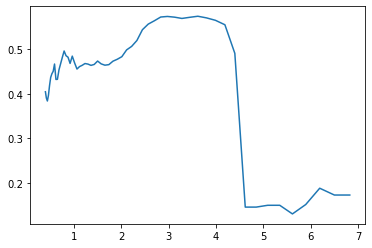

In [227]:
plt.plot(isolistN.sma * 20/nres, isolistN.eps)

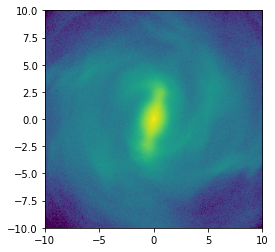

In [265]:
fig, ax = plt.subplots(1, 1)

ax.imshow(dataN.T, origin='lower', extent=[-10, 10, -10, 10], norm=mpl.colors.LogNorm())

# key = np.argmax(isolistN.eps)
# sma = isolistN.sma[key]
# iso = isolistN.get_closest(sma)
# x, y, = iso.sampled_coordinates()
# x = (x-nres/2) * (20/nres)
# y = (y-nres/2) * (20/nres)
# ax.plot(x, y, color='white')



In [215]:
k = np.argmax(isolistN.eps)
isolistN.sma[k] * 20/nres

3.6175781250000005

In [ ]:
isolistS, dataS = get_ellipticity_profile(snS, -phiS)

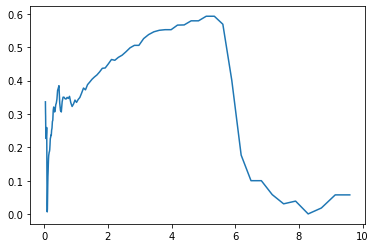

In [172]:
plt.plot(isolistS.sma * 20/nres, isolistS.eps)

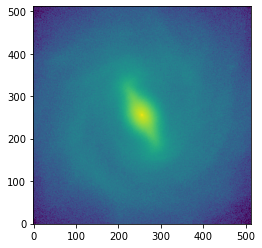

In [173]:
plt.imshow(dataS.T, origin='lower', norm=mpl.colors.LogNorm())

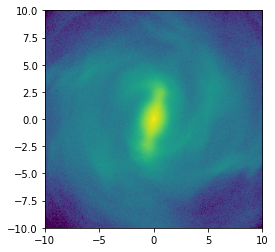

In [185]:
fig, ax = plt.subplots(1, 1)

# key = np.argmax(isolistN.eps)
# sma = isolistN.sma[key]
# iso = isolistN.get_closest(sma)
# x, y, = iso.sampled_coordinates()
# x = (x-nres/2) * (20/nres)
# y = (y-nres/2) * (20/nres)
# ax.plot(x, y, color='white')

center = get_center(None, snN)
data = get_surfdens_map(snN, center)
ax.imshow(dataN.T, origin='lower', extent=[-10, 10, -10, 10], norm=mpl.colors.LogNorm())

## time evolution of properties

In [5]:
basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/gasbar/analysis/ellipse'
fN = np.load(basepath + '/ellipse_Nbody-lvl3.npy', allow_pickle=True).item()
fS = np.load(basepath + '/ellipse_phantom-vacuum-Sg20-Rc3.5-lvl3.npy', allow_pickle=True).item()

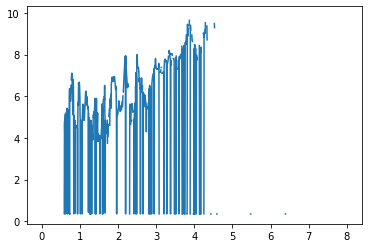

In [6]:
key = np.logical_not(np.isnan(fN['Rbar_PA']))
key = np.logical_and(key, fN['Rbar_PA'] > 0.5)

plt.plot(fN['Time'], fN['Rbar_PA'])

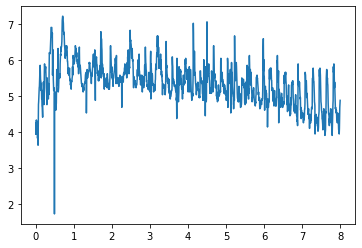

In [9]:
key = np.logical_not(np.isnan(fS['Rbar_PA']))
key = np.logical_and(key, fS['Rbar_PA'] > 0.5)

plt.plot(fS['Time'][key], fS['Rbar_PA'][key])

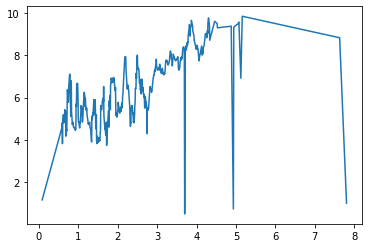

In [11]:
key = np.logical_not(np.isnan(fN['Rbar_PA']))
key = np.logical_and(key, fN['Rbar_PA'] > 0.5)

plt.plot(fN['Time'][key], fN['Rbar_PA'][key])

## Intensity Rbar measurement

In [276]:
def extract_t_A2A0(fourier, idx):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        A2r = fourier[key]['A2r'][idx]
        A2i = fourier[key]['A2i'][idx]
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
        A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_max_A2A0(fourier, debug=False):

    i = 0

    tlist = np.array(fourier['time'])
    A2A0list = []
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = np.array(fourier[key]['A0'])
        A2r = np.array(fourier[key]['A2r'])
        A2i = np.array(fourier[key]['A2i'])
    
        A2 = np.sqrt(A2r*A2r + A2i*A2i)
#         A2A0 = A2/A0
        A2A0list.append(np.max(A2/A0))
        if debug:
            print(tlist[i], fourier[key]['Rlist'][np.argmax(A2/A0)], np.max(A2/A0))
#         A2A0list.append(A2/A0)
        i += 1
    
    return np.array(tlist), np.array(A2A0list)

def extract_t_AmA0(fourier, idx, m):

    i = 0

    tlist = np.array(fourier['time'])
    AmA0list = []
#     print(fourier['snapshot_000']['Rlist'][idx])
    while 'snapshot_'+"{:03d}".format(i) in fourier.keys():
        key = 'snapshot_'+"{:03d}".format(i)
        A0 = fourier[key]['A0'][idx]
        Amr = fourier[key]['A'+str(m)+'r'][idx]
        Ami = fourier[key]['A'+str(m)+'i'][idx]
    
        Am = np.sqrt(Amr*Amr + Ami*Ami)
        AmA0list.append(Am/A0)
        i += 1
    
    return np.array(tlist), np.array(AmA0list)

In [4]:
def get_bar_angle(phi, firstkey):
    out = np.zeros(len(phi))

    # set the first bar anglea
    first_bar_angle = phi[firstkey]/2.0
    out[firstkey] = first_bar_angle
    
    # set all subsequent angles
    for i in np.arange(firstkey+1, len(out)):
        dphi = phi[i] - phi[i-1]
        if dphi < -np.pi:
            dphi += 2.*np.pi
        out[i] = out[i-1] + dphi/2.0

    # set all previous angles to be the bar angle
    for i in np.arange(0, firstkey):
        out[i] = first_bar_angle

    return out

def get_sorted_keys(dat):
    keys = list(dat.keys())
    # only keep keys that are snapshot keys
    keys = [k for k in keys if 'snapshot' in k]

    # extract and sort indices
    indices = [int(re.findall(r'\d?\d?\d\d\d', k)[0]) for k in keys]
    sorted_arg = np.argsort(indices)
    keys_sorted = [keys[i] for i in sorted_arg]

    return keys_sorted

def get_A2_angle(dat, keys, Rbin, cum=False):
    if cum:
        rk = 'A2r_c'
        ri = 'A2i_c'
    else:
        rk = 'A2r'
        ri = 'A2i'
    
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])
    A2r = np.array([np.array(dat[k][rk]) for k in keys])
    A2i = np.array([np.array(dat[k][ri]) for k in keys])
    phi = np.arctan2(A2i, A2r)
    phi = phi[:,Rbin]
    R_at_Rbin = Rlist[:,Rbin]
    
    time = np.array(dat['time'])

    return time, R_at_Rbin, phi

def get_bar_length(dat, keys, Rmin=2, Rmax=10, ratio_cut = 2):
    Rlist = np.array([np.array(dat[k]['Rlist']) for k in keys])

    A0 = np.array([np.array(dat[k]['A0']) for k in keys])
    A1r = np.array([np.array(dat[k]['A1r']) for k in keys])
    A1i = np.array([np.array(dat[k]['A1i']) for k in keys])
    A2r = np.array([np.array(dat[k]['A2r']) for k in keys])
    A2i = np.array([np.array(dat[k]['A2i']) for k in keys])
    A3r = np.array([np.array(dat[k]['A3r']) for k in keys])
    A3i = np.array([np.array(dat[k]['A3i']) for k in keys])
    A4r = np.array([np.array(dat[k]['A4r']) for k in keys])
    A4i = np.array([np.array(dat[k]['A4i']) for k in keys])
    A5r = np.array([np.array(dat[k]['A5r']) for k in keys])
    A5i = np.array([np.array(dat[k]['A5i']) for k in keys])
    A6r = np.array([np.array(dat[k]['A6r']) for k in keys])
    A6i = np.array([np.array(dat[k]['A6i']) for k in keys])
    
    I0 = A0/2.
    I1 = np.sqrt(A1r*A1r + A1i*A1i)
    I2 = np.sqrt(A2r*A2r + A2i*A2i)
    I3 = np.sqrt(A3r*A3r + A3i*A3i)
    I4 = np.sqrt(A4r*A4r + A4i*A4i)
    I5 = np.sqrt(A5r*A5r + A5i*A5i)
    I6 = np.sqrt(A6r*A6r + A6i*A6i)
    
    Ib = I0 + I2 + I4 + I6
    Iib = I0 - I2 + I4 - I6
    
    IbIib = Ib/Iib
    
    Rbar_list = []
    for i,k in enumerate(keys):
        R = Rlist[i,:]
        ratio = IbIib[i,:]
        
        Rkey = np.logical_and(R > Rmin, R< Rmax)
        ratio = ratio[Rkey]
        R = R[Rkey]
        j = 0
        try:
            while ratio[j] > ratio_cut:
                j += 1
            Rbar = R[j-1] + (ratio_cut - ratio[j-1]) * (R[j]-R[j-1])/(ratio[j]-ratio[j-1])
        except:
            Rbar = np.nan
        Rbar_list.append(Rbar)

    time = np.array(dat['time'])    
    
    return time, np.array(Rbar_list)

def evaluate_polynomial(pfit, n, time, bar_angle_firstkey, firstkey):
    pfit_n = pfit[n]
    poly_bar_angle = np.zeros(len(time))
    poly_pattern_speed = np.zeros(len(time))

    for i in range(n+1):
        ba = pfit_n[i] * time ** (n-i)
        poly_bar_angle[firstkey:] += ba[firstkey:]
        ps = (n-i) * pfit_n[i] * time**(n-1-i)
        poly_pattern_speed[firstkey:] += ps[firstkey:]

    poly_bar_angle[:firstkey] += bar_angle_firstkey

    poly_pattern_speed = poly_pattern_speed / u.Myr
    poly_pattern_speed = poly_pattern_speed.to_value(u.km/u.s/u.kpc)

    return poly_bar_angle, poly_pattern_speed

def main_bar_angle(dat, Rbin = 3, firstkey = 150, nmax = 10, cum=False):
    # try loading snapshot
#     dat = h5.File(fname, mode='r')
    out = {}

    keys = get_sorted_keys(dat)
    time, R, phi = get_A2_angle(dat, keys, Rbin, cum=cum)
    time, Rbar = get_bar_length(dat, keys)
#     Rlist, Iibar = get_bar_length(dat, keys)
    bar_angle = get_bar_angle(phi, firstkey)

    pattern_speed = np.gradient(bar_angle, time) / u.Myr
    pattern_speed = pattern_speed.to_value(u.km/u.s/u.kpc)

    pfit = [np.polyfit(time[firstkey:], bar_angle[firstkey:], i) for i in range(nmax)]
    
    out['time'] = time
    out['firstkey'] = firstkey
    out['R'] = R
    out['Rbar'] = Rbar
    out['phi'] = phi
    out['bar_angle'] = bar_angle
    out['pattern_speed'] = pattern_speed
    out['pfit'] = pfit

    # now evaluate the polynomial for each fit and save the result
    out['poly_eval'] = {}
    for n in range(nmax):
        poly_bar_angle, poly_pattern_speed = evaluate_polynomial(pfit, n, time, bar_angle[firstkey], firstkey)

        out['poly_eval'][n] = (poly_bar_angle, poly_pattern_speed)

    return out
#     return Rlist, Iibar

In [6]:
import astropy.units as u

In [282]:
fourier = read_fourier(0, lvl='lvl3')
out = main_bar_angle(fourier, Rbin=3, firstkey=0, cum=True)

<ipython-input-277-db31fcbdb6e4>:111: RuntimeWarning: divide by zero encountered in reciprocal
  ps = (n-i) * pfit_n[i] * time**(n-1-i)
<ipython-input-277-db31fcbdb6e4>:111: RuntimeWarning: invalid value encountered in multiply
  ps = (n-i) * pfit_n[i] * time**(n-1-i)


(0.0, 10.0)

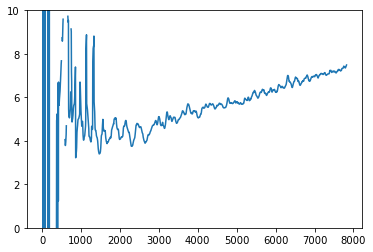

In [287]:
plt.plot(out['time'], out['Rbar'])
plt.ylim(0, 10)

In [7]:
fourier = read_fourier(1, lvl='lvl3')
out = main_bar_angle(fourier, Rbin=3, firstkey=0, cum=True)

<ipython-input-4-db31fcbdb6e4>:111: RuntimeWarning: divide by zero encountered in reciprocal
  ps = (n-i) * pfit_n[i] * time**(n-1-i)
<ipython-input-4-db31fcbdb6e4>:111: RuntimeWarning: invalid value encountered in multiply
  ps = (n-i) * pfit_n[i] * time**(n-1-i)


(0.0, 10.0)

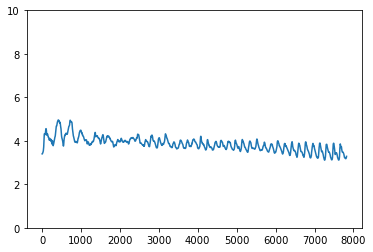

In [8]:
plt.plot(out['time'], out['Rbar'])
plt.ylim(0, 10)